# Мастерская: модель, предсказывающая жизнеспособность стартапов

**Задача**: необходимо работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются.

В ходе работы в пройдете все основные этапы полноценного исследования:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

In [1]:
# Установка библиотек
!pip install phik 
!pip install shap
!pip install scikit-learn==1.1.3 -q
!pip install optuna-integration
# !pip install numpy --upgrade
# !pip install matplotlib --upgrade

In [2]:
import pandas as pd
#import seaborn as sns
import numpy as np
import sklearn
import shap
import optuna

In [3]:
import seaborn as sns

In [4]:
# Выгрузим библиотеки и инструменты для работы

from datetime import datetime
from phik import phik_matrix

# Инструменты.
from pkg_resources import Distribution
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif
from phik.report import plot_correlation_matrix
from scipy import stats as st
from matplotlib import pyplot as plt
from phik import phik_matrix
import warnings
from optuna.integration import OptunaSearchCV
warnings.filterwarnings("ignore")

In [5]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## ЭТАП 1. Загрузка и ознакомление с данными
На данном этапе прочитаем имеющиеся данные и изучим информацию о них.

### Тренировочные данные

In [6]:
df_train = pd.read_csv("kaggle_startups_train_28062024.csv")
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


В тренировочных данных обнаружено большое количество пропусков.\
В столбцах founded_at, first_funding_at, last_funding_at и closed_at необходимо изменить тип на дату.

In [8]:
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'])
df_train['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'])
df_train['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'])
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'])

In [9]:
df_train.describe()

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


### Тестовые данные

In [10]:
df_test = pd.read_csv("kaggle_startups_test_28062024.csv")
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [12]:
df_test['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'])
df_test['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'])

In [13]:
df_test.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


In [14]:
status = pd.read_csv("kaggle_startups_sample_submit_28062024.csv")
status.head(3)

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed


In [15]:
status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


## ЭТАП 2. Предварительная обработка


### Проверка на наличие дубликатов в данных

In [16]:
status.duplicated().sum()

0

In [17]:
df_train.duplicated().sum()

0

In [18]:
df_test.duplicated().sum()

0

В данных отсутствуют явные дубликаты.

### Добавление признака lifetime в тренировочные данные

Мы видим, что в тренировочных данных есть дата основания стартапа, а также дата закрытия, а в тестовых данных есть только срок жизни компании.\
Целесообразно добавить в тренировочные данные столбец со сроком жизни компании и потом удалить дату сонования/закрытия.

In [19]:
# Заполним пропущенные данные в столбце с закрытием компании последним днем выгрузки (01.01.2018)
df_train['closed_at'] = df_train['closed_at'].fillna(pd.to_datetime('2018-01-01'))
# Добавим столбец со сроком существования компании в днях period of operation
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days
# Удалим из тренировочных данных лишние столбцы
df_train = df_train.drop(['closed_at', 'founded_at'], axis=1)

In [20]:
df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383


### Обработка пропусков

In [21]:
# Выведем количество пропусков
df_train.isnull().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
first_funding_at         0
last_funding_at          0
lifetime                 0
dtype: int64

In [22]:
# Проставим нули в отсутствующих данных о сумме финансирования
df_train['funding_total_usd'] = df_train['funding_total_usd'].fillna(df_train['funding_total_usd'].median())

In [23]:
# В пропущенных категориальных данных заменим пропуски на other (для name - Unknown)
df_train['name'] = df_train['name'].fillna('Unknown')
df_train['category_list'] = df_train['category_list'].fillna('other')
df_train['country_code'] = df_train['country_code'].fillna('other')
df_train['state_code'] = df_train['state_code'].fillna('other')
df_train['region'] = df_train['region'].fillna('other')
df_train['city'] = df_train['city'].fillna('other')

In [24]:
# Выведем количество пропусков
df_test.isnull().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [25]:
# Проставим нули в отсутствующих данных о сумме финансирования
df_test['funding_total_usd'] = df_test['funding_total_usd'].fillna(df_test['funding_total_usd'].median())

In [26]:
# В пропущенных категориальных данных заменим пропуски на other (для name - Unknown)
df_test['category_list'] = df_test['category_list'].fillna('other')
df_test['country_code'] = df_test['country_code'].fillna('other')
df_test['state_code'] = df_test['state_code'].fillna('other')
df_test['region'] = df_test['region'].fillna('other')
df_test['city'] = df_test['city'].fillna('other')

### Укрупнение данных по регионам

In [27]:
df_train['country_code'].unique()

array(['CHE', 'USA', 'other', 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND',
       'KOR', 'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY',
       'PRT', 'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL',
       'DEU', 'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC',
       'ROM', 'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR',
       'GHA', 'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA',
       'NOR', 'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC',
       'CZE', 'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO',
       'UKR', 'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV',
       'COL', 'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB',
       'SRB', 'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD',
       'UZB', 'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN',
       'HND', 'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT',
       'IRN', 'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM',
       'TGO', 'RWA

In [28]:
# Создадим функцию, которая будет указывать регион страны по ISO 3166-1 alpha-3
def country_region(country):
    regions = {
        'Central Africa' : ['RWA'],
        'Central America' : ['BLZ', 'CRI', 'GTM', 'HND', 'MEX', 'NIC', 'PAN', 'SLV'],
        'Central Asia' : ['KAZ', 'UZB'],
        'Central Europe' : ['AUT', 'CHE', 'CZE', 'HUN', 'LIE', 'SVK'],
        'East Asia' : ['CHN', 'HKG', 'JPN', 'KOR', 'TWN'],
        'Eastern Africa' : ['KEN', 'SOM', 'TAN', 'UGA'],
        'Eastern Europe' : ['BLR', 'EST', 'LTU', 'LVA', 'MDA', 'POL', 'UKR'],
        'Indian Ocean' : ['MUS', 'SYC'],
        'no_region' : ['other'],
        'North America' : ['CAN', 'USA'],
        'Northern Africa' : ['DZA', 'EGY', 'MAR', 'TUN'],
        'Northern Asia' : ['RUS'],
        'Northern Europe' : ['DNK', 'FIN', 'ISL', 'NOR', 'SWE'],
        'Pacific' : ['AUS', 'NZL'],
        'South America' : ['ARG', 'BRA', 'CHL', 'COL', 'ECU', 'PER', 'PRY', 'URY', 'VEN'],
        'South Asia' : ['BGD', 'IND', 'LKA', 'NPL', 'PAK'],
        'South East Asia' : ['BRN', 'IDN', 'KHM', 'LAO', 'MMR', 'MYS', 'PHL', 'SGP', 'THA', 'VNM'],
        'South East Europe' : ['ALB', 'BGR', 'GRC', 'HRV', 'MKD', 'MNE', 'ROM', 'SRB', 'SVN'],
        'South West Asia' : ['ARE', 'ARM', 'AZE', 'BHR', 'CYP', 'GEO', 'IRN', 'ISR', 'JOR', 'KWT', 'LBN', 'OMN', 'PSE', 'QAT', 'SAU', 'TUR'],
        'South West Europe' : ['ESP', 'GIB', 'PRT'],
        'Southern Africa' : ['BWA', 'MOZ', 'ZAF', 'ZMB', 'ZWE'],
        'Southern Europe' : ['ITA', 'MLT'],
        'West Indies' : ['BAH', 'BLM', 'BMU', 'CYM', 'DOM', 'GRD', 'JAM', 'KNA', 'MAF', 'PRI', 'TTO', 'BRB', 'DMA'],
        'Western Africa' : ['CMR', 'GHA', 'NGA', 'SEN', 'TGO', 'CIV'],
        'Western Europe' : ['BEL', 'DEU', 'FRA', 'GBR', 'GGY', 'IRL', 'JEY', 'LUX', 'MCO', 'NLD']
    }
    for k in regions.keys():
        if country in regions[k]:
            return k

df_train.loc[:, 'region'] = df_train.loc[:, 'country_code'].apply(country_region)
df_test.loc[:, 'region'] = df_test.loc[:, 'country_code'].apply(country_region)

df_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Central Europe,Zürich,2,2011-05-01,2014-12-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,North America,Redwood City,4,2010-05-04,2014-02-25,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,North America,San Jose,3,2012-08-20,2014-07-02,4383


In [29]:
# Удалим лишние столбцы с кодом страны, городом и кодом штата
df_train = df_train.drop(['country_code', 'state_code', 'city'], axis=1)
df_test = df_test.drop(['country_code', 'state_code', 'city'], axis=1)
df_train.head(3)

,name,category_list,funding_total_usd,status,region,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,Central Europe,2,2011-05-01,2014-12-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,North America,4,2010-05-04,2014-02-25,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,North America,3,2012-08-20,2014-07-02,4383


### Группировка категорий

In [30]:
df_train['category_list'].nunique()

22106

In [31]:
# выделяю первое значение категории из значений в category_list
df_train.loc[:, 'main_category'] = df_train.loc[:, 'category_list'].map(lambda x: str.split(x.strip(), sep='|')[0])
df_test.loc[:, 'main_category'] = df_test.loc[:, 'category_list'].map(lambda x: str.split(x.strip(), sep='|')[0])
df_train.head(3)

,name,category_list,funding_total_usd,status,region,funding_rounds,first_funding_at,last_funding_at,lifetime,main_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,Central Europe,2,2011-05-01,2014-12-01,2998,Online Reservations
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,North America,4,2010-05-04,2014-02-25,4748,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,North America,3,2012-08-20,2014-07-02,4383,Biotechnology


In [32]:
# Удалим лишние столбцы с кодом страны, городом и кодом штата
df_train = df_train.drop('category_list', axis=1)
df_test = df_test.drop(['category_list'], axis=1)
df_train.head(3)

,name,funding_total_usd,status,region,funding_rounds,first_funding_at,last_funding_at,lifetime,main_category
0,Lunchgate,828626.0,operating,Central Europe,2,2011-05-01,2014-12-01,2998,Online Reservations
1,EarLens,42935019.0,operating,North America,4,2010-05-04,2014-02-25,4748,Manufacturing
2,Reviva Pharmaceuticals,35456381.0,operating,North America,3,2012-08-20,2014-07-02,4383,Biotechnology


In [33]:
df_train['main_category'].nunique()

708

In [34]:
# Проверит категории из тестовых данных, которых нет в тренировочных
not_in_train = []
dict_cat = df_train['main_category'].unique()
for i in df_test['main_category'].unique():
    if i not in dict_cat:
        not_in_train.append(i)
print(not_in_train)

['Fmcg', 'Usability', 'Social Buying', 'Mobile Shopping', 'Experience Design', 'Subscription Businesses', 'Vacation Rentals', 'Direct Advertising', 'Musicians', 'Homeless Shelter', 'GreenTech', 'Group Email', 'Senior Health', 'Gay & Lesbian', 'EDA Tools', 'Darknet', 'Private School', 'Real Estate Investors', 'Mens Specific', 'Testing']


### Группировка по длительности жизни

In [35]:
percentiles = [0.05, 0.3, 0.5, 0.7, 0.95]
round(df_train['lifetime'].quantile(percentiles)/365)

0.05     3.0
0.30     5.0
0.50     7.0
0.70    10.0
0.95    20.0
Name: lifetime, dtype: float64

In [36]:
def lifecycle_cat(lifetime):
  
    if lifetime < 365 * 3:
        return 'менее 3 лет'
    elif lifetime <= 365 * 5:
        return '3-5 лет'
    elif lifetime <= 365 * 7:
        return '5-7 лет'
    elif lifetime <= 365 * 10:
        return '7-10 лет'
    elif lifetime <= 365 * 20:
        return '10-20 лет'
    else:
        return 'более 20 лет'

df_train.loc[:, 'lifetime_category'] = df_train['lifetime'].apply(lifecycle_cat)
df_test.loc[:, 'lifetime_category'] = df_test['lifetime'].apply(lifecycle_cat)

In [37]:
df_train.head()

,name,funding_total_usd,status,region,funding_rounds,first_funding_at,last_funding_at,lifetime,main_category,lifetime_category
0,Lunchgate,828626.0,operating,Central Europe,2,2011-05-01,2014-12-01,2998,Online Reservations,7-10 лет
1,EarLens,42935019.0,operating,North America,4,2010-05-04,2014-02-25,4748,Manufacturing,10-20 лет
2,Reviva Pharmaceuticals,35456381.0,operating,North America,3,2012-08-20,2014-07-02,4383,Biotechnology,10-20 лет
3,Sancilio and Company,22250000.0,operating,no_region,3,2011-09-01,2014-07-18,5114,Health Care,10-20 лет
4,WireTough Cylinders,2000000.0,operating,North America,1,2012-02-01,2012-02-01,2791,Manufacturing,7-10 лет


In [38]:
df_test.head()

,name,funding_total_usd,region,funding_rounds,first_funding_at,last_funding_at,lifetime,main_category,lifetime_category
0,Crystalsol,2819200.0,Central America,1,2011-05-01,2014-12-01,3501,Clean Technology,7-10 лет
1,JBI Fish & Wings,2000000.0,North America,1,2010-05-04,2014-02-25,2717,Hospitality,7-10 лет
2,COINPLUS,428257.0,Western Europe,2,2012-08-20,2014-07-02,1295,Finance,3-5 лет
3,Imagine Communications,34700000.0,North America,4,2011-09-01,2014-07-18,4748,Software,10-20 лет
4,DNA13,4530000.0,North America,1,2012-02-01,2012-02-01,6209,Software,10-20 лет


### Группировка по годам раундов

In [39]:
# Вытащим годы из дат и удалим даты
df_train['first_funding_year'] = df_train['first_funding_at'].dt.year
df_train['last_funding_year'] = df_train['last_funding_at'].dt.year

df_test['first_funding_year'] = df_test['first_funding_at'].dt.year
df_test['last_funding_year'] = df_test['last_funding_at'].dt.year

df_train = df_train.drop(['first_funding_at', 'last_funding_at'], axis=1)
df_test = df_test.drop(['first_funding_at', 'last_funding_at'], axis=1)

## ЭТАП 3. Разведочный анализ

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                52516 non-null  object 
 1   funding_total_usd   52516 non-null  float64
 2   status              52516 non-null  object 
 3   region              52516 non-null  object 
 4   funding_rounds      52516 non-null  int64  
 5   lifetime            52516 non-null  int64  
 6   main_category       52516 non-null  object 
 7   lifetime_category   52516 non-null  object 
 8   first_funding_year  52516 non-null  int64  
 9   last_funding_year   52516 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ MB


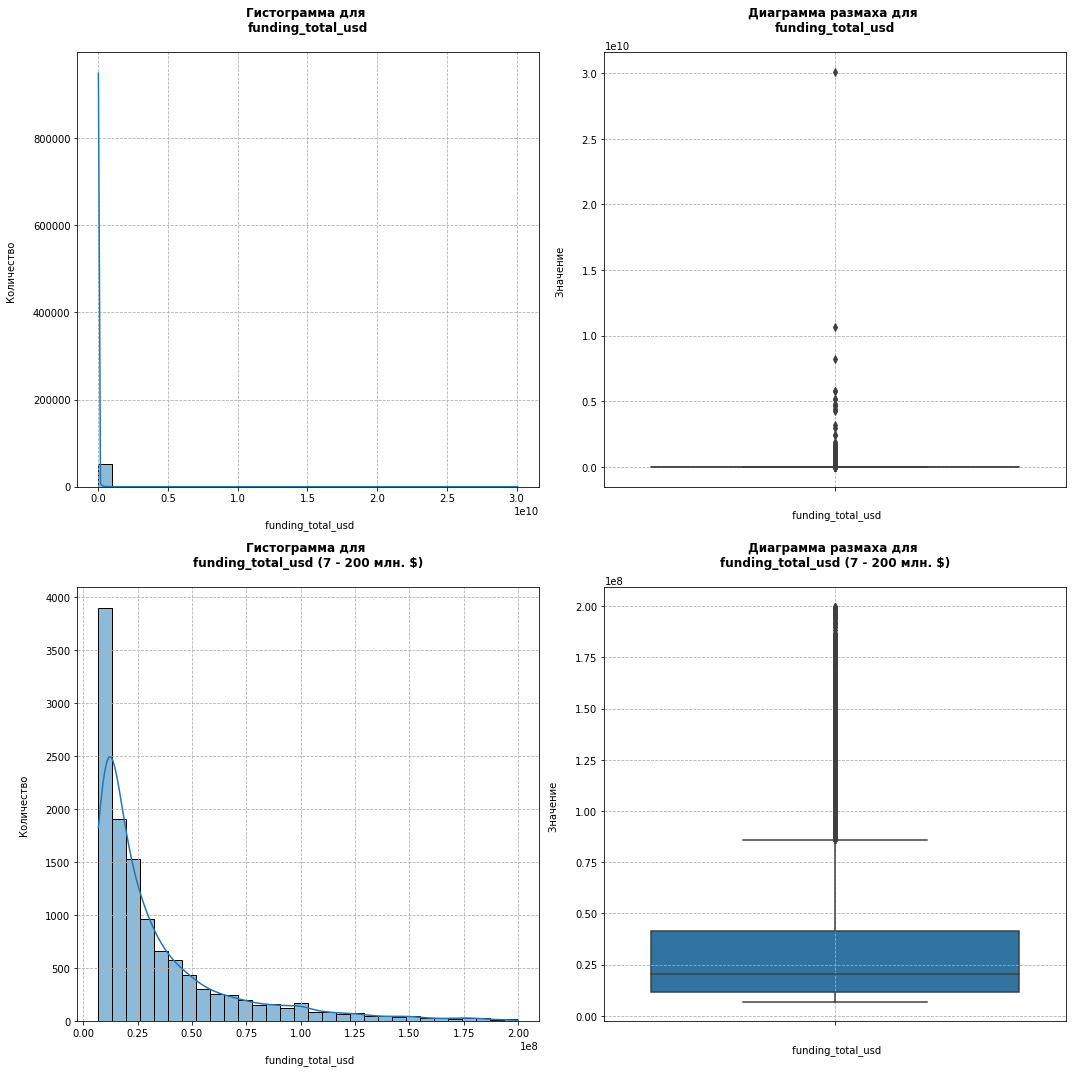

In [41]:
# делаю сетку для 3 графиков методом subplots
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(15, 15))

# гистограмма с графиком плотности
sns.histplot(df_train['funding_total_usd'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].ticklabel_format(axis='x')
axs[0, 0].set_xlabel('\n ' + 'funding_total_usd')
axs[0, 0].set_ylabel('Количество \n')
axs[0, 0].set_title('Гистограмма для \n' + 'funding_total_usd' + '\n', 
                    color='black', fontweight ='bold')
axs[0, 0].grid(linestyle='--')

# диаграмма размаха
sns.boxplot(y=df_train['funding_total_usd'], ax=axs[0, 1])
axs[0, 1].ticklabel_format(axis='y')
axs[0, 1].set_xlabel('\n ' + 'funding_total_usd')
axs[0, 1].set_ylabel('Значение \n')
axs[0, 1].set_title('Диаграмма размаха для \n' + 'funding_total_usd' + '\n', 
                    color='black', fontweight ='bold')
axs[0, 1].grid(linestyle='--')

# гистограмма с графиком плотности
sns.histplot(df_train.query('7000000 < funding_total_usd < 200000000')['funding_total_usd'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].ticklabel_format(axis='x')
axs[1, 0].set_xlabel('\n ' + 'funding_total_usd')
axs[1, 0].set_ylabel('Количество \n')
axs[1, 0].set_title('Гистограмма для \n' + 'funding_total_usd' + ' (7 - 200 млн. $)' + '\n', 
                    color='black', fontweight ='bold')
axs[1, 0].grid(linestyle='--')

# диаграмма размаха
sns.boxplot(y=df_train.query('7000000 < funding_total_usd < 200000000')['funding_total_usd'], ax=axs[1, 1])
axs[1, 1].ticklabel_format(axis='y')
axs[1, 1].set_xlabel('\n ' + 'funding_total_usd')
axs[1, 1].set_ylabel('Значение \n')
axs[1, 1].set_title('Диаграмма размаха для \n' + 'funding_total_usd' + ' (7 - 200 млн. $)' + '\n', 
                    color='black', fontweight ='bold')
axs[1, 1].grid(linestyle='--')

plt.tight_layout()

In [42]:
# исключаю выбросы в funding_total_usd с примененем функции .query()
df_train = df_train.query('funding_total_usd < 100000000')

## ЭТАП 4. Проверка на мультиколлинеарность

In [43]:
df_train['funding_rounds'] = df_train['funding_rounds'].astype('int32')
df_train['lifetime'] = df_train['lifetime'].astype('int32')
df_train['first_funding_year'] = df_train['first_funding_year'].astype('int32')
df_train['last_funding_year'] = df_train['last_funding_year'].astype('int32')
df_train['funding_total_usd'] = df_train['funding_total_usd'].astype('float32')

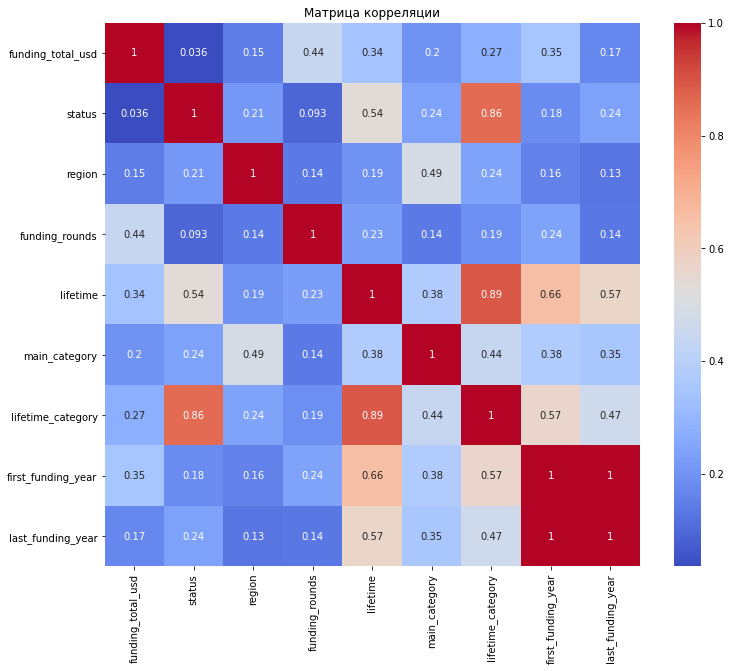

In [44]:
corr_matrix = df_train.drop('name', axis=1).phik_matrix(interval_cols = ['funding_total_usd', 
                                                    'funding_rounds', 
                                                    'lifetime', 
                                                    'first_funding_year', 
                                                    'last_funding_year'])
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show();

In [45]:
df_train.head()

,name,funding_total_usd,status,region,funding_rounds,lifetime,main_category,lifetime_category,first_funding_year,last_funding_year
0,Lunchgate,828626.0,operating,Central Europe,2,2998,Online Reservations,7-10 лет,2011,2014
1,EarLens,42935020.0,operating,North America,4,4748,Manufacturing,10-20 лет,2010,2014
2,Reviva Pharmaceuticals,35456380.0,operating,North America,3,4383,Biotechnology,10-20 лет,2012,2014
3,Sancilio and Company,22250000.0,operating,no_region,3,5114,Health Care,10-20 лет,2011,2014
4,WireTough Cylinders,2000000.0,operating,North America,1,2791,Manufacturing,7-10 лет,2012,2012


## ЭТАП 5. Отбор финального набора обучающих признаков

In [46]:
# Разбиваем выборку на входные и валидационные признаки
X = df_train.drop([
    'name',
    'last_funding_year',
    'first_funding_year',
    'main_category',
    'lifetime',
    'status'
], axis=1)
y = df_train['status']

# Разбиваем тренировочные и валидационные признаки на тренировочные и валидационные
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

# Получаем имена категориальных и количественных признаков
cat_columns = X.select_dtypes(exclude='number').columns.tolist()
num_columns = X.select_dtypes(include='number').columns.tolist()

# С помощью LabelEncoder кодируем целевой признак, как 0 и 1 (closed и  perating)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.fit_transform(y_valid)


# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )


# SimpleImputer + Scaler
num_pipe = Pipeline(
    [
        ('sImputer_nan_med', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# создаю общий пайплайн подтоговки данных
# для моделей использующих градиентный спуск и евклидово расстояние
data_preprocessor = ColumnTransformer(
    [
        ('cat', ohe_pipe, cat_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

## ЭТАП 6. Выбор и обучение моделей

In [47]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['region',
                                                                                'lifetime_category']),
                                                                              ('num',
                                                                               Pipeline(steps=[('sImputer_na...
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 7),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(C=1,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='f1')

In [48]:
best_model = randomized_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['region',
                                                   'lifetime_category']),
                                                 ('num', StandardScaler(),
                                     

# ЭТАП 7. Оценка качества предсказания лучшей модели

In [49]:
X_test = df_test.drop([
    'name',
    'last_funding_year',
    'first_funding_year',
    'main_category',
    'lifetime'
], axis=1)
y_test = status['status']

In [50]:
# С помощью LabelEncoder кодируем целевой признак, как 0 и 1 (closed и  perating)
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

In [51]:
y_test_pred = randomized_search.best_estimator_.predict(X_test)
print(f'Метрика f1_score на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Метрика f1_score на тестовой выборке: 0.6501041833627184


# ЭТАП 8. Анализ важности признаков модели

In [52]:
X_train_shap = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

feature_names = randomized_search.best_estimator_[:-1].get_feature_names_out()
X_train_shap = pd.DataFrame(data=X_train_shap, columns=feature_names)

explainer = shap.LinearExplainer(
    randomized_search.best_estimator_.named_steps['models'],
    X_train_shap
)

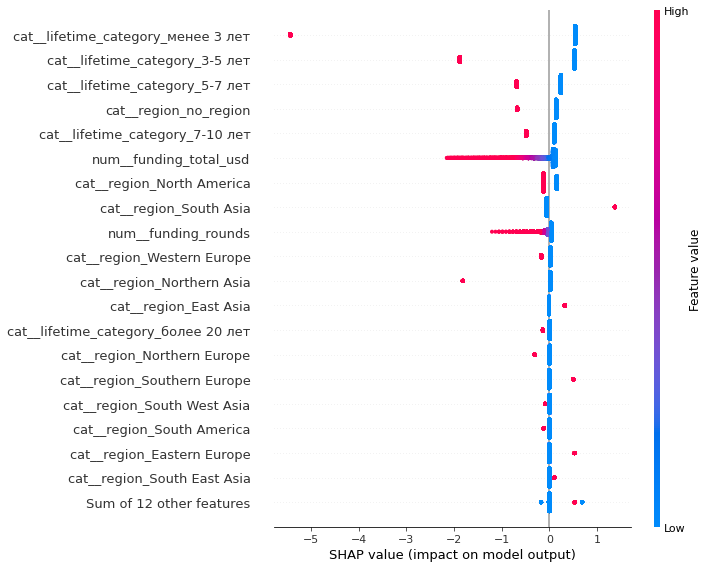

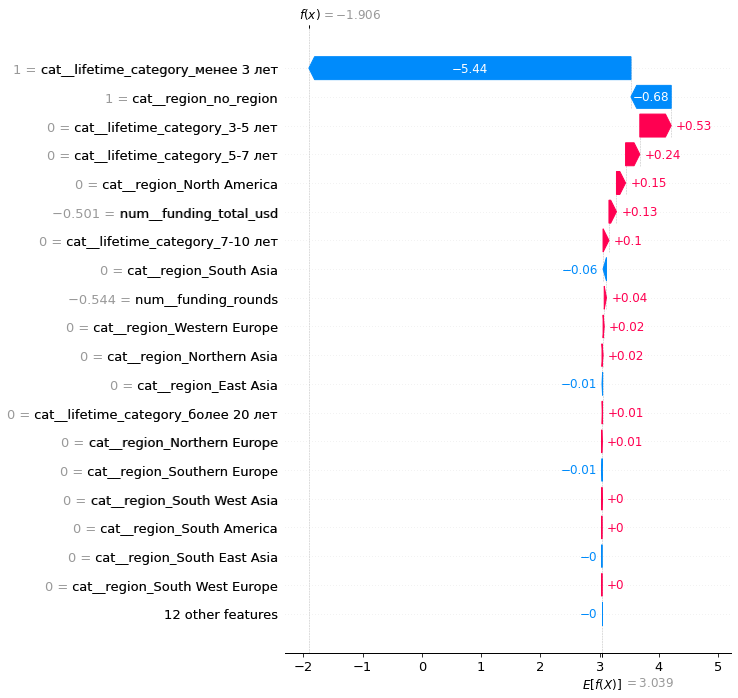

In [53]:
explainer = shap.LinearExplainer(
    randomized_search.best_estimator_.named_steps['models'],
    X_train_shap
)

feature_names = randomized_search.best_estimator_[:-1].get_feature_names_out()
X_train_shap = pd.DataFrame(data=X_train_shap, columns=feature_names)

shap_values = explainer(X_train_shap)

shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.waterfall(shap_values[5], max_display=20) 
#display(shap.plots.bar(shap_values, max_display=23)

In [55]:
randomized_search.best_estimator_[:-1].get_feature_names_out()

array(['cat__region_Central America', 'cat__region_Central Asia',
       'cat__region_Central Europe', 'cat__region_East Asia',
       'cat__region_Eastern Africa', 'cat__region_Eastern Europe',
       'cat__region_Indian Ocean', 'cat__region_North America',
       'cat__region_Northern Africa', 'cat__region_Northern Asia',
       'cat__region_Northern Europe', 'cat__region_Pacific',
       'cat__region_South America', 'cat__region_South Asia',
       'cat__region_South East Asia', 'cat__region_South East Europe',
       'cat__region_South West Asia', 'cat__region_South West Europe',
       'cat__region_Southern Africa', 'cat__region_Southern Europe',
       'cat__region_West Indies', 'cat__region_Western Africa',
       'cat__region_Western Europe', 'cat__region_no_region',
       'cat__lifetime_category_3-5 лет', 'cat__lifetime_category_5-7 лет',
       'cat__lifetime_category_7-10 лет',
       'cat__lifetime_category_более 20 лет',
       'cat__lifetime_category_менее 3 лет', 'num__

In [56]:
X_test_shap = pipe_final.named_steps['preprocessor'].fit_transform(X_test)

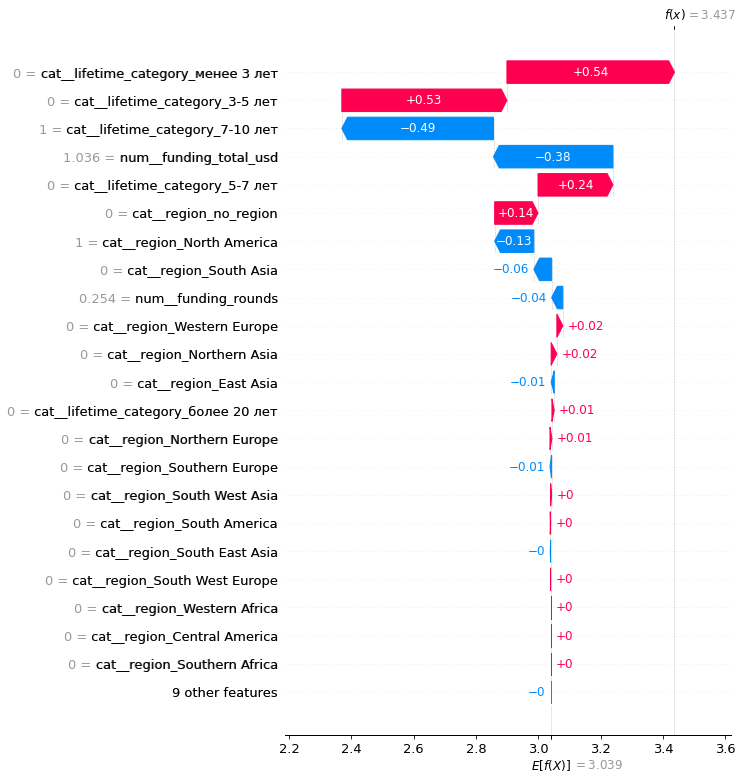

In [57]:
shap.plots.waterfall(shap_values[1], max_display=23)

# ЭТАП 9. Отчет по исследованию

Заказчик попросил решить следующие задачи:

Разработать модель машинного обучения для предсказания продолжения деятельности стартапа.

Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность бизнес идеи).

Заказчик предоставил данные в 2 файлах: тренировочный набор (около 53 тыс. записей) и тестовый набор (около 13 тыс. записей). Cтолбцы с датами в датафрейме типизированы верно, за исключением колонки 'closed_at' в тренировочных данных. Нет столбцов с неверными десятичными разделителями.

Датафрейм df_train состоит из 52 514 строк и 13 столбцов, имеет колонки с пропусками.
Датафрейм df_test состоит из 13 125 строк и 11 столбцов, имеет колонки с пропусками.

Замечено, что в датафрейме df_train есть колонка 'closed_at' а в df_test она отсутствует и добавлена 'lifetime'.

В процессе предобработки данных:

наименования колонок не требовали преобразования;
обнаружены и заменены пропуски;
исправлен тип данных для признака closed_at, колонки с 64-битными числовыми значениями преобразованы в 32-битные для оптимизации использования памяти;
явных дубликатов, требующих дополнительной обработки не обнаружено. Но обнаружены дубликаты в данных без колонки name;
добавлены новые колонки: 'region', 'lifetime', 'founded_at_year', 'last_fund_year', 'lifetime_category', 'main_category'.

Предобработка потребовала незначительного удаления информации, потому 100% данных представлено к дальнейшему анализу.

Результат исследовательского анализа

исключены выбросы из df_train - объекты с общим объёмом инвестиций более 100 млн. долларов

проведён корреляционный анализ для тренировочного датафрейма


Обнаруженные особенности:

Выполнена подготовка данных для применениях в моделях машинного обучения с помощью пайплайнов. Проведена замена целевого признака с помощью LabelEncoder.

В рамках решения задачи классификации - прогнозирование статуса стартапа, были выбраны и обучены 3 модели: LogisticRegression, kNN, DecisionTreeClassifier. Поиск гиперпараметров вёлся с помощью RandomizedSearchCV. Метрика считалась на кросс-валидации. Лучшей моделью является логистическая регрессия. LogisticRegression показала хорошую метрику F1: 0.97.

Выполнен поиск лучших признаков, которые дают максимальное значение метрики F1. 

Выполненная работа над проектом позволяет составить некоторые рекомендации:

бОльшая часть стартапов из предоставленного датасета находятся в странах североамериканского и западноевропейского региона. Что говорит о развитой культуре открытия новых компаний. У предпринимателя будет высокая конкуренция, но и более высокий шанс на успех;
количество раундов инвестирования и общая сумма финансирования не сильно влияют на жизнеспособность стратапа;
наиболее большое количество как действующих, так и закрытых стартапов работают в сфере биотехнологий, разработки приложений, web-приложений, электронной коммерции и рекламы. Учитывая несбалансированность количества действующих и закрытых стартапов в пользу первых, участие предпринимателя в указанных сферах предоставят высокие шансы на успех;
медианное время жизни закрывшегося стартапа - 3 года. Важно преодолеть этот период.